In [1]:
%reload_ext autoreload
%autoreload 2
# from pywinusb import hid
from lib.DMDpycrafter import DMDhid
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
from lib.DMD import DmdDeviceHID

In [3]:
images=[]
img = np.asarray(PIL.Image.open("testimage.tif"))//129
img2 = np.asarray(PIL.Image.open("testimage2.tif"))//129
img3 = np.asarray(PIL.Image.open("testimage3.tif"))//129
h = (1600-1080)/2
w = (2560-1920)/2
img = np.pad(img, ((int(np.floor(h)), int(np.ceil(h))), (int(np.floor(w)), int(np.ceil(w)))), 'constant', constant_values=(0.5, 0.5))
img2 = np.pad(img2, ((int(np.floor(h)), int(np.ceil(h))), (int(np.floor(w)), int(np.ceil(w)))), 'constant', constant_values=(0.5, 0.5))
img3 = np.pad(img3, ((int(np.floor(h)), int(np.ceil(h))), (int(np.floor(w)), int(np.ceil(w)))), 'constant', constant_values=(0.5, 0.5))

images.append(img)
images.append(img2)
images.append(img3)

In [2]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [94]:
def checkerboard(shape):
    return np.indices(shape).sum(axis=0) % 2

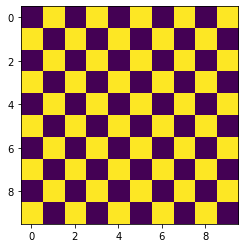

In [95]:
plt.imshow(checkerboard((10, 10)))

In [105]:
circle = create_circular_mask(1600, 2560, radius=461) # 53 laser 0.8 mm, 461 7mm pinhole size
circle[int(1600/2-25):int(1600/2+25), :] = True
circle[:,int(2560/2-25):int(2560/2+25)] = True
circle = np.zeros((1600, 2560))==0
circle = checkerboard((2, 2))==True

tilew = np.tile([[0]], reps=[20, 20])
tileb = np.tile([[1]], reps=[20, 20])
tilew = np.tile([[0]], reps=[20, 20])
tileb = np.tile([[1]], reps=[20, 20])
v1 = np.vstack([tilew, tileb])
v2 = np.vstack([tileb, tilew])
v = np.hstack([v1, v2])

circle = np.tile(v, reps=[40, 64])
images=[~circle]

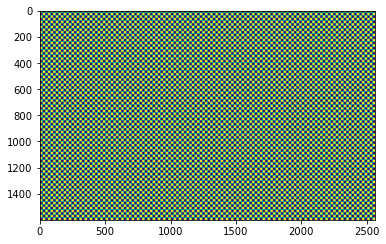

In [106]:
plt.imshow(~circle)

In [107]:
dmd = DMDhid()
dmd.stopsequence()
dmd.changemode(3)
exposure=[10000000]*30
dark_time=[0]*30
trigger_in=[False]*30
trigger_out=[1]*30
dmd.defsequence(images,exposure,trigger_in,dark_time,trigger_out,0)


merging...
encoding...
29812
29812
uploading...
0 60
0 60


In [108]:
dmd.startsequence()